Movie Recommender System using Collaborative Filtering Methods - Sanity check
-----------------

The dataset was downloaded from Kaggle: https://www.kaggle.com/datasets/ranitsarkar01/movies-recommender-system-dataset

In [1]:
# Utilities libraries
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import pymc as pm
import aesara.tensor as at
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\distutils\system_info.py:2159: UserWarning: 
    Optimized (vendor) Blas libraries are not found.
    Falls back to netlib Blas library which has worse performance.
    A better performance should be easily gained by switching
    Blas library.
  if self._calc_info(blas):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\distutils\system_info.py:2159: UserWarning: 
    Blas (http://www.netlib.org/blas/) libraries not found.
    Directories to search for the libraries can be specified in the
    numpy/distutils/site.cfg file (section [blas]) or by setting
    the BLAS environment variable.
  if self._calc_info(blas):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\distutils\system_info.py:2159: UserWarning: 
    Blas (http://www.netlib.org/blas/) sources not found.
    Directories to search for the sources can be specified in the
    numpy/distutils/sit

Let's explore the dataset

From the dataset, we know that the files follow this format:
- movies.dat:  MovieID::Title::Genres
- ratings.dat: UserID::MovieID::Rating::Timestamp
- users.dat:   UserID::Gender::Age::Occupation::Zip-code

Let's explore the movies dataset: MovieID::Title::Genres

In [2]:
df_movies = pd.read_csv('./Dataset/movies.dat', sep='::', engine='python', names=['MovieID', 'Title', 'Genres'],  encoding='ISO-8859-1')

In [3]:
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


As it can be seen, the Genres are read in the same column. Let's split the genres column and apply one-hot encoding:

In [4]:
genres_split = df_movies['Genres'].str.get_dummies(sep='|')

In [5]:
genres_split.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
df_movies = pd.concat([df_movies, genres_split], axis=1)

In [7]:
df_movies.head()

,MovieID,Title,Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Animation|Children's|Comedy,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's modify more this dataset with movies, so that the year of the movie is moved to another column

In [8]:
# Extract year from the Title and create a new column 'Year'
df_movies['YearMovie'] = df_movies['Title'].str.extract(r'\((\d{4})\)')

# Remove the year from the Title column 
df_movies['Title'] = df_movies['Title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()



In [9]:
df_movies.head()

,MovieID,Title,Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,YearMovie
0,1,Toy Story,Animation|Children's|Comedy,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji,Adventure|Children's|Fantasy,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men,Comedy|Romance,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale,Comedy|Drama,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,5,Father of the Bride Part II,Comedy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995


In [10]:
print(f'There are {len(df_movies)} movies.')

There are 3883 movies.


Let's explore the ratings file:

it has the following format: UserID::MovieID::Rating::Timestamp

In [11]:
df_ratings = pd.read_csv('./Dataset/ratings.dat', sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'],  encoding='ISO-8859-1')
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [12]:
print(f'There are {len(df_ratings)} ratings.')

There are 1000209 ratings.


Let's explore the users file:

In [13]:
df_users = pd.read_csv('./Dataset/users.dat', sep='::', engine='python', names=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode'],  encoding='ISO-8859-1')
df_users.head()

,UserID,Gender,Age,Occupation,ZipCode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [14]:
print(f'There are {len(df_users)} users.')

There are 6040 users.


Note:
- Age is chosen from the following ranges:
	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

Merging datasets
------------------

In [219]:
# Merge ratings with movies
df_ratings_movies = pd.merge(df_ratings, df_movies, on='MovieID')

# Merge the result with users
df_full = pd.merge(df_ratings_movies, df_users, on='UserID')

df_full.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Action,Adventure,Animation,Children's,...,Romance,Sci-Fi,Thriller,War,Western,YearMovie,Gender,Age,Occupation,ZipCode
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,0,0,0,0,...,0,0,0,0,0,1975,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical,0,0,1,1,...,0,0,0,0,0,1996,F,1,10,48067
2,1,914,3,978301968,My Fair Lady,Musical|Romance,0,0,0,0,...,1,0,0,0,0,1964,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich,Drama,0,0,0,0,...,0,0,0,0,0,2000,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A",Animation|Children's|Comedy,0,0,1,1,...,0,0,0,0,0,1998,F,1,10,48067


Prepare dataset for HPF
-------------------

Ensure that data is in correct format, i.e., ensure that UserID and MovieID are sequential (and start from 0).
(common requierement for matrix factorization algorithms)

Use only 10 users (for sanity check) and later use more
--------------

In [220]:
f_full_safe_copy = df_full.copy(deep=True)

In [221]:
len(set(df_full_safe_copy['UserID']))

6040

In [222]:
filtered_by_id = df_full_safe_copy[df_full_safe_copy['UserID'] <=10].copy(deep = True)
df_full = filtered_by_id.copy(deep = True)
len(df_full)

1200

In [71]:
# df_full_safe_copy = df_full.copy(deep=True)
df_full = filtered_by_id.sample(frac=0.05)
len(df_full)

452

In [40]:
# df_full = filtered_by_id.copy(deep = True)
# len(df_full)

1200

In [223]:
len(df_full)

1200

Split the dataset into train and test
-------------------

We can either choose a random split, a temporal split, or a user-based split (or all). For the purpose of this project, the data will be split based on time and user presence. Reasons:
- Time-split:  because it includes a timestamp for each rating; ---> ratings up to a certain date for the training  and the ratings after that date for testing.
- User-based split: Ensures that every user present in the test set is also present in the training set; the model needs past data about the user to make predictions for them.

This approach seems more realistic because it simulates how the model would work in production, predicting future ratings based on past data. Moreover, we can insure that every movie in the test set has appeared in the training set.

Data split for sanity check: random split + user-based split:
------------------

Random split: Split the data into 1% train and 99% for test. This is done for sanity check, and the percentage of the test set is much higher because after the user-based split, the test set will become much smaller.

In [232]:
train_data_random, test_data_random = train_test_split(df_full, test_size=0.99, random_state=42)

User-Based Data Split
------------

Ensure that every user and movie in the test set is also present in the training set.

In [233]:
# Identify users and movies in the training set
train_users = set(train_data_random['UserID'])
train_movies = set(train_data_random['MovieID'])

In [234]:
# Filter the test set to only include users and movies that are also in the training set
test_data = test_data_random[test_data_random['UserID'].isin(train_users) & test_data_random['MovieID'].isin(train_movies)]

In [238]:
train_data = train_data_random

In [241]:
print(f"The new percentages are: {len(train_data)/len(df_full)} train data and {len(test_data)/len(df_full)} test data.")
print("These percentages are relative to the dataset containg 10 users.\n")

print(f"Length of the train sample: {len(train_data)}.")
print(f"Length of the test sample: {len(test_data)}")

datasetlen = len(train_data) + len(test_data)
ratio_test = len(test_data)/datasetlen
ratio_train = len(train_data)/datasetlen

print(f"The final percentages are: {ratio_train}% train; {ratio_test}% test.")

The new percentages are: 0.01 train data and 0.006666666666666667 test data.
These percentages are relative to the dataset containg 10 users.

Length of the train sample: 12.
Length of the test sample: 8
The final percentages are: 0.6% train; 0.4% test.


Factorization of the Training Set
-----------

In [242]:
user_id_mapping = {original_id: numerical_id for numerical_id, original_id in enumerate(train_data['UserID'].unique())}
movie_id_mapping = {original_id: numerical_id for numerical_id, original_id in enumerate(train_data['MovieID'].unique())}

In [243]:
# Apply the mapping on the set:
train_data['numerical_user_id'] = train_data['UserID'].map(user_id_mapping)
train_data['numerical_movie_id'] = train_data['MovieID'].map(movie_id_mapping)

Factorization of the Test Set
---------------

Apply the SAME mapping as on the training set

In [244]:
test_data['numerical_user_id'] = test_data['UserID'].map(user_id_mapping)
test_data['numerical_movie_id'] = test_data['MovieID'].map(movie_id_mapping)

C:\Users\User\AppData\Local\Temp\ipykernel_26168\2070996432.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['numerical_user_id'] = test_data['UserID'].map(user_id_mapping)
C:\Users\User\AppData\Local\Temp\ipykernel_26168\2070996432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['numerical_movie_id'] = test_data['MovieID'].map(movie_id_mapping)


Check for missing values:

In [245]:
if test_data.isna().sum().any() or train_data.isna().sum().any():
    print("NaN values, STOP")
else:
    print("Test and train data OK!")

Test and train data OK!


Implementation of the model - Sanity Check
---------------

In [246]:
# Number of users and movies in the sampled dataset
n_users= train_data['numerical_user_id'].nunique()
n_movies = train_data['numerical_movie_id'].nunique()

In [247]:
# Extract rating and IDs
user_ids = train_data['numerical_user_id'].values
movie_ids = train_data['numerical_movie_id'].values
ratings = train_data['Rating'].values

Model specification definition

In [132]:
# Hyperparameters for the Gamma distributions
alpha = beta = 0.3
n_factors = 10

with pm.Model() as hierarchical_poisson_model:
    # User and item latent factors
    user_factors = pm.Gamma('user_factors', alpha=alpha, beta=beta, shape=(n_users, n_factors))
    item_factors = pm.Gamma('item_factors', alpha=alpha, beta=beta, shape=(n_movies, n_factors))
    
    # Get the user and item factors for each rating
    user_factors_ratings = user_factors[user_ids, :]
    item_factors_ratings = item_factors[movie_ids, :]
    
    # Calculate the rate parameter (lambda) for the Poisson distribution
    # Element-wise multiplication and sum across the latent factors dimension
    rate = pm.math.sum(user_factors_ratings * item_factors_ratings, axis=1)
    
    # The observed ratings
    ratings_obs = pm.Poisson('ratings_obs', mu=rate, observed=ratings)


Model training

In [133]:
# Run the Model
with hierarchical_poisson_model:
    # Inference button (MCMC)
    trace = pm.sample(1000, return_inferencedata=True)


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1044 seconds.


Model saving

In [211]:

# Save the trace to a NetCDF file
with hierarchical_poisson_model:
    az.to_netcdf(trace, 'hierarchical_poisson_model_trace.nc')


Model evaluation (sanity check)
-----------------

array([[<Axes: title={'center': 'user_factors'}>,
        <Axes: title={'center': 'user_factors'}>],
       [<Axes: title={'center': 'item_factors'}>,
        <Axes: title={'center': 'item_factors'}>]], dtype=object)

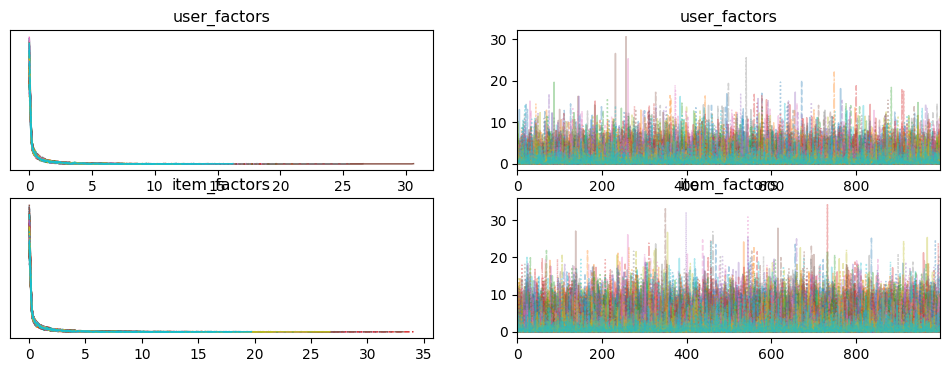

In [135]:
# Plot the trace for theta and beta so that convergence is ensured
az.plot_trace(trace)

The left subplots show the density plots or marginal posterior distribution for the parameters. The overlapping lines suggest that different chains are converging to similar distribution.

The right subplots (theta and beta) show the sampled values at each step in the MCMC siulation. What should be 'good' to see here is hairy caterpillars, where some samples mix nicely accross the entire value range (indicating good mixture and convergence). 

For theta: The density plot on the left seems to show that the distribution of the samples is converging to a certain shape (which looks like it could be a Gamma distribution due to the long tail). 
The trace plot on the right looks a bit concerning because it shows quite a bit of "spikiness" and does not exhibit the typical "hairy caterpillar" look. This might suggest poor mixing or that the chains have not converged.

For beta: The chains seem to be exploring a wide range of values, and there isn't a clear indication that they are settling down to a stable distribution.

Let's see the summary of the posterior distribution for parameters

In [136]:
summary = az.summary(trace)
summary.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"user_factors[0, 0]",0.807,1.427,0.0,3.125,0.022,0.017,2562.0,1859.0,1.0
"user_factors[0, 1]",0.815,1.332,0.0,3.205,0.021,0.015,2614.0,2075.0,1.0
"user_factors[0, 2]",0.805,1.397,0.0,3.209,0.022,0.016,2210.0,1570.0,1.0
"user_factors[0, 3]",0.804,1.373,0.0,2.997,0.020,0.015,2587.0,1703.0,1.0
"user_factors[0, 4]",0.792,1.385,0.0,3.051,0.021,0.015,2476.0,1550.0,1.0


Let's do some Posterior Predictive Checks (PPC). This let us asses how well the model predicts the observed data. 

For HPF, we want to compare the predicted ratings against the actual ratings.

In [252]:
with hierarchical_poisson_model:
    # Generate posterior predictive samples
    ppc_hpc = pm.sample_posterior_predictive(trace, var_names=['ratings_obs'])

Sampling: [ratings_obs]


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\arviz\plots\ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\arviz\plots\ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='ratings_obs'>

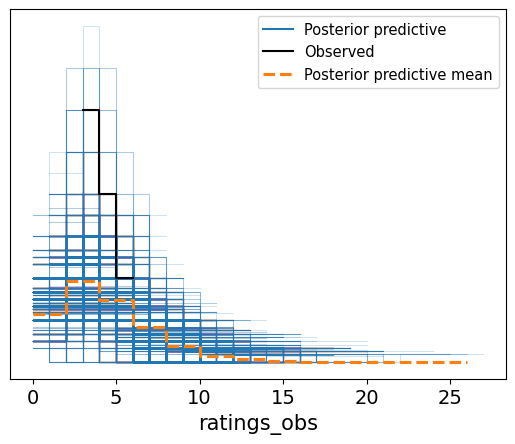

In [253]:
# Plot the PPC results
az.plot_ppc(ppc_hpc)

In [332]:
ppc_hpc

Inference data with groups:
	> posterior_predictive
	> observed_data

Let's plot the observed data-rating (which comes from the train set)

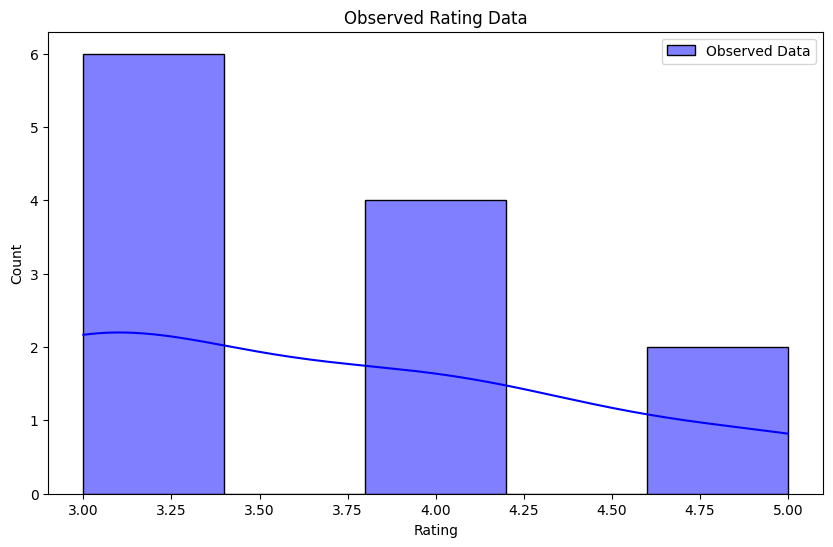

In [368]:
# Plotting Observed data
observed_data = ppc_hpc.observed_data['ratings_obs'].data
plt.figure(figsize=(10, 6))
sns.histplot(observed_data, kde=True, color='b', label='Observed Data')
plt.title('Observed Rating Data')
plt.xlabel('Rating')
plt.legend()
plt.show()

Let's plot the mean posterior predictive:

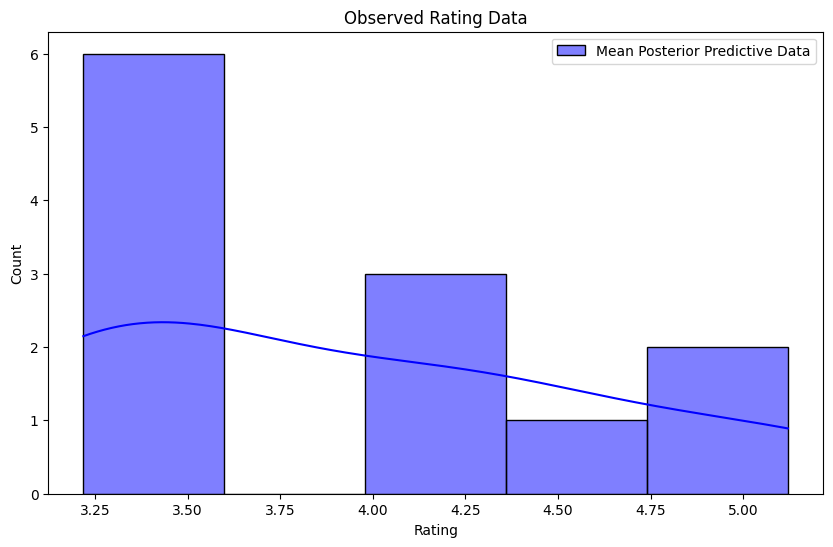

In [369]:
# Plotting Observed data
mean_posterior_predictive= ppc_hpc.posterior_predictive['ratings_obs'].mean(dim=('chain', 'draw'))
plt.figure(figsize=(10, 6))
sns.histplot(mean_posterior_predictive, kde=True, color='b', label='Mean Posterior Predictive Data')
plt.title('Observed Rating Data')
plt.xlabel('Rating')
plt.legend()
plt.show()

Let's plot both of them in a single graph

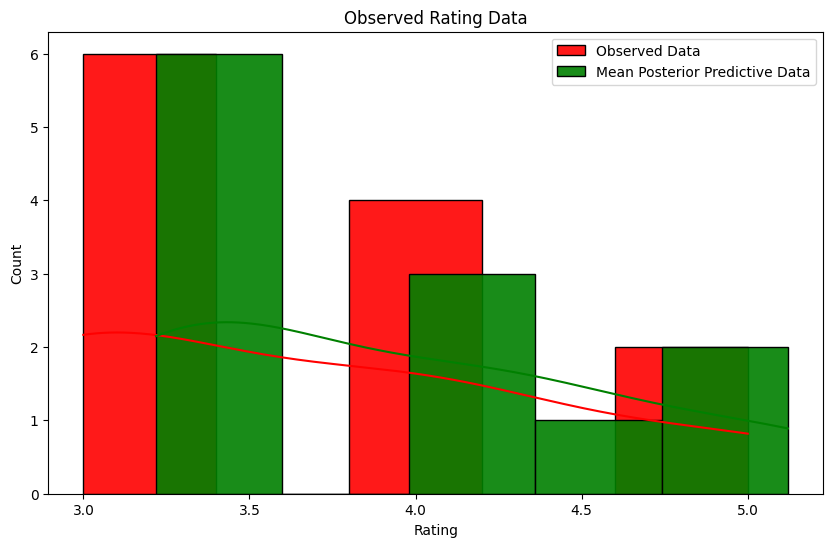

In [377]:
# Plotting Observed data and Posterior predictive

plt.figure(figsize=(10, 6))
sns.histplot(observed_data, kde=True, color='r',alpha=0.9, label='Observed Data')
sns.histplot(mean_posterior_predictive, kde=True, color='g',alpha=0.9, label='Mean Posterior Predictive Data')
plt.title('Observed Rating Data')
plt.xlabel('Rating')
plt.legend()
plt.show()

Let's do a posterior predictive check for first rating

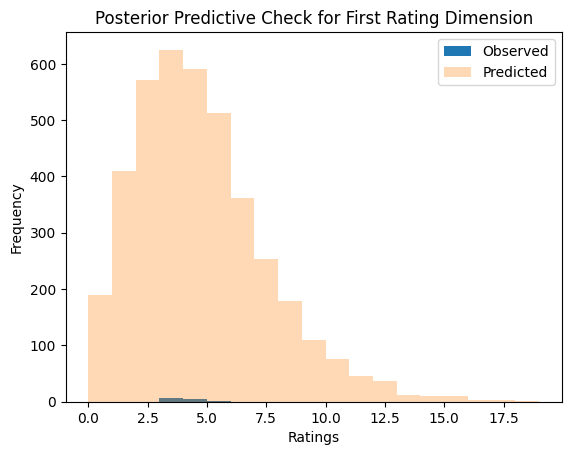

In [367]:
# Extract the predicted ratings for the first rating dimension 
predicted_ratings = ppc_hpc.posterior_predictive['ratings_obs'].isel(ratings_obs_dim_2=1)
# Flatten the predicted ratings to get a 1-dimensional array
predicted_ratings_flat = predicted_ratings.values.flatten()

# Plotting the observed ratings
plt.hist(observed_data, bins=range(min(observed_data), max(observed_data) + 2), alpha=1, label='Observed')

# Plotting the predicted ratings
plt.hist(predicted_ratings_flat, bins=range(min(predicted_ratings_flat), max(predicted_ratings_flat) + 2), alpha=0.3, label='Predicted')

plt.legend()
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Posterior Predictive Check for First Rating Dimension')
plt.show()



Evaluation of the model on the test set:
------------------------


In [353]:
# Extract test data
test_user_ids = test_data['numerical_user_id'].values
test_movie_ids = test_data['numerical_movie_id'].values
test_ratings = test_data['Rating'].values

In [354]:
# Extract rating and IDs
test_user_ids = train_data['numerical_user_id'].values
test_movie_ids = train_data['numerical_movie_id'].values
test_ratings = train_data['Rating'].values

In [355]:
with pm.Model() as prediction_model:
    # User and item latent factors
    user_factors = pm.Gamma('user_factors', alpha=alpha, beta=beta, shape=(n_users, n_factors))
    item_factors = pm.Gamma('item_factors', alpha=alpha, beta=beta, shape=(n_movies, n_factors))
    
    # Get the user and item factors for each rating in the test set
    user_factors_test = user_factors[test_user_ids, :]
    item_factors_test = item_factors[test_movie_ids, :]
    
    # Calculate the rate parameter (lambda) for the Poisson distribution for the test set
    rate_test = pm.math.sum(user_factors_test * item_factors_test, axis=1)
    
    # The observed ratings for the test set
    # Here, we're not observing the ratings but setting up the structure for prediction
    ratings_obs_test = pm.Poisson('ratings_obs_test', mu=rate_test, observed=test_ratings)


In [357]:
with prediction_model:
    # Use the parameter values from the trained model (trace)
    ppc = pm.sample_posterior_predictive(trace, var_names=['ratings_obs_test'])


Sampling: [ratings_obs_test]


In [403]:
# Calculate the mean predicted ratings across all chains and draws
mean_predicted_ratings = ppc.posterior_predictive['ratings_obs_test'].mean(dim=('chain', 'draw'))
mean_predicted_ratings


<xarray.DataArray 'ratings_obs_test' (ratings_obs_test_dim_2: 12)>
array([5.053  , 4.152  , 3.308  , 5.09   , 4.24475, 3.425  , 4.34875,
       3.9835 , 3.306  , 3.29425, 3.46725, 3.30025])
Coordinates:
  * ratings_obs_test_dim_2  (ratings_obs_test_dim_2) int32 0 1 2 3 ... 8 9 10 11

In [404]:
mean_predicted_ratings = mean_predicted_ratings.values
mean_predicted_ratings

array([5.053  , 4.152  , 3.308  , 5.09   , 4.24475, 3.425  , 4.34875,
       3.9835 , 3.306  , 3.29425, 3.46725, 3.30025])

In [405]:
# Calculate RMSE with mean predicted ratings
rmse = np.sqrt(mean_squared_error(test_ratings, mean_predicted_ratings))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE using mean predicted ratings
mae = mean_absolute_error(test_ratings, mean_predicted_ratings)
print(f"Mean Absolute Error (MAE) with clipped predictions: {mae}")


Root Mean Squared Error (RMSE): 0.28577308342167795
Mean Absolute Error (MAE) with clipped predictions: 0.25047916666666664


Let's also calculate the 'accuracy' (similar to a classification model) by considering a tolerance. In reality, it accuracy cannot be used for this model, but this comparison is done just for fun:

In [414]:
# Convert predictions and actual ratings to numpy arrays
predicted_ratings_acc = mean_predicted_ratings.ravel()  # Flatten if it's 2D
actual_ratings = test_ratings.ravel()  # Flatten 

# Definition of a tolerance threshold
tolerance = 0.4

# Calculate whether each prediction is within the tolerance of the actual rating
correct_predictions = np.abs(predicted_ratings_acc - actual_ratings) <= tolerance

# Calculate the proportion of predictions that are correct
accuracy = correct_predictions.mean()
print(f"Accuracy (with tolerance ±{tolerance}): {accuracy}")


Accuracy (with tolerance ±0.4): 0.8333333333333334


Now let's round the predicted ratings, so that we get an integer rating, and thus compare its accuracy without any tolerance!

In [425]:
rounded_predicted_ratings = np.round(mean_predicted_ratings).astype(int)
accuracy_score(test_ratings, rounded_predicted_ratings)

1.0

Because the ratings (some of them) are higher than 5, and we know that the maximum rating is 5, we can clip those predictions between 1 and 5!

In [426]:
clipped_predictions = np.clip(mean_predicted_ratings, 1, 5)
# Calculate RMSE using clipped predictions
rmse = np.sqrt(mean_squared_error(test_ratings, clipped_predictions))
print(f"Root Mean Squared Error (RMSE) with clipped predictions: {rmse}")

# Calculate MAE using clipped predictions
mae = mean_absolute_error(test_ratings, clipped_predictions)
print(f"Mean Absolute Error (MAE) with clipped predictions: {mae}")

Root Mean Squared Error (RMSE) with clipped predictions: 0.28417806367663206
Mean Absolute Error (MAE) with clipped predictions: 0.23856249999999998


Conclusion of the sanity check
----------------

After many trials, the hierarchical poisson model seems to work fine (on a very small datase <0.1% of the total data). Another model (10% of the dataset) was running for 20 hours and only 10% of it converged! Therefore, for the larger model, I will use 20 users!